<a href="https://colab.research.google.com/github/caroheymes/jedha_final_project/blob/master/keywords_selection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Foreword 

This notebook shows how to efficiently select relevant keywords from multiple searches on Google Ads (> 400 files for 100K expressions int the present case).

On second thought, if it were required to industrialize the process, a module should be developped to manage directly the api calls on Google Ads.

# Load Packages

In [ ]:
!pip install spacy -q
!python -m spacy download fr_core_news_sm -q
!pip install unidecode
!pip install unidecode
!pip install wordcloud -q
!pip install stylecloud
!pip install matplotlib==3.4
!pip install random2


In [2]:

import os
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

import fr_core_news_sm
import string
import unidecode
from unidecode import unidecode
import re
import pandas as pd
import json
from fnmatch import fnmatch
import random

# Import matplotlib and wordcloud 
import chardet
import spacy
import fr_core_news_sm
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import wordcloud
from spacy.lang.fr.stop_words import STOP_WORDS
import numpy as np
from PIL import Image
from collections import Counter


import warnings; warnings.filterwarnings(action='ignore')
import time


import seaborn as sns
%matplotlib inline
large = 18; med = 14; small = 11
params = {'axes.titlesize': large,
          'legend.fontsize': small,
          'figure.figsize': (16, 8),
          'axes.labelsize': small,
          'axes.titlesize': small,
          'xtick.labelsize': small,
          'ytick.labelsize': small,
          'figure.titlesize': med}
plt.rcParams.update(params)
plt.style.use('seaborn-whitegrid')
sns.set_style("white")

Mounted at /content/drive/


In [4]:
trash = pd.read_csv('/content/drive/MyDrive/111_goldfinger/data_collection/all_pages/+++conso.csv')
trash.columns

Index(['Unnamed: 0', 'canonical', 'content', 'h1', 'h2', 'h3', 'h4',
       'header_links_href', 'header_links_text', 'meta_desc', 'nav_links_text',
       'raw_url', 'title', 'searchTerms', 'rank', 'displayLink', 'link',
       'content_len'],
      dtype='object')

# Load keyword files

All keywords have been exported from Google Ads

In [ ]:
os.chdir('/content/drive/MyDrive/111_goldfinger/kw/all_files')


# List all keyword files
pattern = "Keyword Stats*.csv"
i=0
liste = []
root = '/content/drive/MyDrive/111_goldfinger/kw/all_files'
for path, subdirs, files in os.walk(root):
    for name in files:
        if fnmatch(name, pattern):
            liste.append(name)
            i+=1
print('Files count : ', len(liste))

# Detecting encoding
with open(random.choice(liste), 'rb') as file:
    encoding = chardet.detect(file.read())
    var = ''.join(encoding['encoding'].split(':'))
print('Necessary encoding to use for integration : ',var)

# Csv compilation
cols = ['Keyword', 'Avg. monthly searches', 'Competition (indexed value)']
df = pd.DataFrame(columns=cols)

for k,v in enumerate(liste):
  try:
    temp = pd.read_csv(liste[k],usecols=cols, encoding=var, sep= '\t',skiprows=2)
    df = pd.concat([df, temp],axis=0)
    if k % 100 == 0:
      print('*****  ', k, 'done ! Remaining ', len(liste) - k, ' files to load... *****')
  except:
    pass


new_cols = ['keyword', 'volume', 'competition']
df = df.rename(columns=dict(zip(df.columns, new_cols)))

#Copy in any case
# df.to_csv('all_kw.csv')

print()
print("Done. Shape of the df DataFrame : ", df.shape)


Files count :  411
Necessary encoding to use for integration :  UTF-16
*****   0 done ! Remaining  411  files to load... *****
*****   100 done ! Remaining  311  files to load... *****
*****   200 done ! Remaining  211  files to load... *****
*****   300 done ! Remaining  111  files to load... *****
*****   400 done ! Remaining  11  files to load... *****

Done. Shape of the df DataFrame :  (117876, 3)


In [ ]:
df.sample(3)


,keyword,volume,competition
309,peugeot 208 hybride prix,500.0,25.0
330,technicienne en stimulation du langage emploi,50.0,NaN
217,garmin 830 prix,50.0,100.0


This dataset has generated a lot of "noise" and a quick cleaning is necessary

In [ ]:
#First easy selection
df1 = df[df.keyword.str.contains('emploi|cdi|cdd|interim|intérim|caces', na=False, case=False) & (df.volume > 1)]
print(df1.shape)

(11763, 3)


In [ ]:
df1.sample()

,keyword,volume,competition
53,preparateur en pharmacie interim,50.0,47.0


In [ ]:
# Statistic cleaning
df2 = df.copy()

def clean(c):
   
    c = c.lower()
    # c = re.sub("\d+", " ", c) #chiffres    
    c = unidecode(c)
    c = c.replace('offre d emploi', 'offre_d_emploi')
    c = c.replace('offre emploi', 'offre_emploi')
    c = re.sub("(\s?)([0-9]{1,1000})", " ", c)  #digits
    c = re.sub("(\s)([a-z]{1})\s ", " ", c)    #lettres seules
    c = c.replace('  ', ' ')
    c = c.strip()
    if c is not None:
      if c not in STOP_WORDS:
        return c
df2['cc'] = df2.apply(lambda x: clean(x['keyword']), axis=1)

In [ ]:
df2.sample(5)

,keyword,volume,competition,cc
647,peugeot 2008 de 2018,500.0,8.0,peugeot de
82,directeur commercial luxe,50.0,6.0,directeur commercial luxe
9,offre d emploi responsable operationnel en tra...,NaN,NaN,offre_d_emploi responsable operationnel en tra...
392,tiguan r line 2013,500.0,3.0,tiguan r line
450,carandache paul smith,50.0,99.0,carandache paul smith


In [ ]:
# Filter the keywords with volume
empty = (df2.cc =='') | (df2.cc.isna()) 
print(df2[empty].shape)
df2 = df2[(~empty) & (df2.volume > 10) ]
df2 = df2.drop_duplicates(subset=['cc'])
df2.sample(5)


(3868, 4)


,keyword,volume,competition,cc
38,canon pg 545 black,50.0,100.0,canon pg black
186,new balance 327 homme white,500.0,100.0,new balance homme white
882,nike 270 react grise,50.0,100.0,nike react grise
137,société cherche chauffeur livreur,50.0,NaN,societe cherche chauffeur livreur
380,doc martens 1460 gaucho,50.0,100.0,doc martens gaucho


In [ ]:
# List of expression for statistic analysis
df2.cc.values

array(['offre_d_emploi informaticien', 'offre_d_emploi agent de quai',
       'offre_d_emploi plombier chauffagiste', ..., 'lir  v',
       'liasse fiscale et', 'cerfa et annexes'], dtype=object)

In [ ]:
df2.dropna(inplace=True)
new = ''.join(df2.cc.values)
tokens =  pd.DataFrame(Counter(new.split(' ')).most_common())
#Save our list of tokens for further analysis
tokens[0].to_csv('/content/tokens.csv')

Given their frequency, we quickly look at the off-topic keywords from a semantic point of view  

⚡ We detect with the `tokens.csv` file, the off-topic terms: car brands, tires and motorcycles, phone and computer brands, sports, geography, ... 
These terms are concatenated and assigned to the 'pattern' variable

In [ ]:

pattern = 'peugeot |bilan|attestation|pile|abarth|amazon|renata|logitech|master|agenda|cabin|crossclimate|association|duracell|porsche |max |gti |auchan|formulaire|geforce |ktm |gt |air |gb |hp |balance |phone |carrera |super |duke |prix |turbo |romeo |adventure |gaming |rx |garmin |alfa |martens |nike |ducati |canon |honda |bmw |cartouche |sw |rs |edge |agent |levis |code |gbgtx |xl |encre |boxster |asus |new |ferrari |occasion |samsung |go |pas |msi |nvidia |targa |gts |strix |office |coupe |note |fiat |abarth |line |noir |cayman |kawasaki |xp |puretech |ram |rog |forerunner |cabriolet |zxr |gti |sporsche |gigabyte |black |smc |react |android |xs |yamaha |prixpeugeot |windows |gbmsi |tigtx |ocgtx |hdi |husqvarna |italia |occasionporsche |armor |scott |jordan |davidson |gbnvidia |ggtx |soignante |pascal |miui |pista |spyder |ninja |microsoft |dodge |gbgeforce |gbgigabyte |goiphone |aorus |pg |xiaomi |stihl |epson |adventurektm |tondeuse |prixporsche |windforce |iron |break |gps |gris |departement |cabrioletporsche |gbrx |xlcartouche |suzuki |imprimante |ssd |blanche |redmi |socket |gtporsche |roomba |amp |rugby |itx |chromebook |dr |hybride |occasionpeugeot |enduro |amazon |avis |phoenix |peugeotpeugeot |lite |levi |pixma |rally |apple |forza |intel |gasus |music |toner |white |grise |beige |prime |gogtx |volvo |btwin |skoda |achat |tarif |xasus |carte |huile |vario |gtktm |visio |brown |hobby |david |santa |excel |pompe |trail |gbxfx |barca |touch |color |crush |jesus |glide |swift |dacia |magna |pixel |zasus |pasus |belle |prixs |ibiza |punto |ready |conan |cerfa |payer |solde |golf |acer |vw |rose |jantes |akrapovic |roulement |notebook |ecran |pitaka |huawei |jailbreak |cdiscount |ali express |chaine |poco |oxygen |book |boursorama |reanault |panasonic |bw |chaussure |compresseur |echappement |xtrons |antenne |youtube |catalogue |peugeotkm |cvpeugeot |clio |viking |logiciel |zalandoa |newbalance |adidas |outlook |mixpeugeot |consommation |mutpeugeot |citroen |bbs |galaxy |configurateur |webasto |argus |carplay |aramis |boite |mlmenew |pgbk |amphanew |amd |pescarolo |bafa |focal |proto |camping |configurator |mercedes |jamoatmospeugeot |dbncthorn |philips |harley |aperto |moteur |volkswagen |pieces |cbr |velocompact |interieur |zcaecartouche |bolt |aliexpress |irobot |video |radio |wallpaper |phare |pression |vidange |airbag |nokia |flight |cesu |support |largeur |partes |grimbergen |uefa |maserati |penthouse |malavita |liasse |impot |iban |fiscal |formulaire |attestation |annexe |pdf |soft |foot |food |laptop | pro |calendrier |sfr |free |orange |magicbook |oneplus |avis  |new balance |scooter |scolaire |crédit agricole |credit agricole |dpt  |semaine |michelin |pirelli |pneu |moto |d2partement |dep  |reconditionn |estanguet| cher |imprim |fisca|gratuit|1|2|3|4|5|6|7|8|9|0|gtx |tignieu|superduke|veretz|dept| var|pyrénée|pyrene|yveline|xadv|fonky|heim|alsace|diavel|world|general|moselle|chevilly|marne|levi\'s|daytona|constantinople|essonne|chelsea|barcelon|harley|pref|mbk|pfizer|préf|ville|region|région|yvelynes|sortir|paris|fb|gsxf|saint| en | sur |seine|yvelynes|france|danemark|www|facebook|psg|argent|insta|cent|boxster|yeezy|film|boost|soft|vespa|meteofr|corona|virus|ducati|adidas|zidane|meteofrance|covid|département|steel|delonghi|cpam'
df2 = df2[~df2.keyword.str.contains(pattern, na=False, case=False)]
df2

,keyword,volume,competition,cc
0,offre d emploi informaticien,500.0,40.0,offre_d_emploi informaticien
2,offre d emploi plombier chauffagiste,500.0,43.0,offre_d_emploi plombier chauffagiste
10,emploi plombier,500.0,55.0,emploi plombier
11,emploi plombier chauffagiste,500.0,32.0,emploi plombier chauffagiste
12,plombier emploi,50.0,48.0,plombier emploi
...,...,...,...,...
67,indeed chef de cuisine,50.0,7.0,indeed chef de cuisine
167,chef de cuisine indeed,50.0,4.0,chef de cuisine indeed
170,chef gerant cuisine collective,50.0,21.0,chef gerant cuisine collective
207,chef gerant cuisine,50.0,43.0,chef gerant cuisine


In [ ]:

# # We concatenate the two batches of correct keywords
data  =  pd.concat([df1, df2], axis=0).drop_duplicates(subset=['keyword'])
data = data[(data.volume > 1) |~(data.volume.isna() )] #keywords that drive trafic !
data.drop_duplicates(subset=['keyword'], inplace=True)
data = data[['keyword', 'volume', 'competition']]
data

,keyword,volume,competition
0,offre d emploi informaticien,500.0,40.0
1,offre d emploi agent de quai,50.0,30.0
2,offre d emploi plombier chauffagiste,500.0,43.0
10,emploi plombier,500.0,55.0
11,emploi plombier chauffagiste,500.0,32.0
...,...,...,...
68,employé polyvalent station service,50.0,13.0
67,indeed chef de cuisine,50.0,7.0
167,chef de cuisine indeed,50.0,4.0
170,chef gerant cuisine collective,50.0,21.0


In [ ]:
data.competition.fillna(1, inplace=True)  #no empty values

In [ ]:
data.to_csv('/content/drive/MyDrive/111_goldfinger/data_collection/results/correct_keywords.csv')

**Statistic display of the most frequent terms**

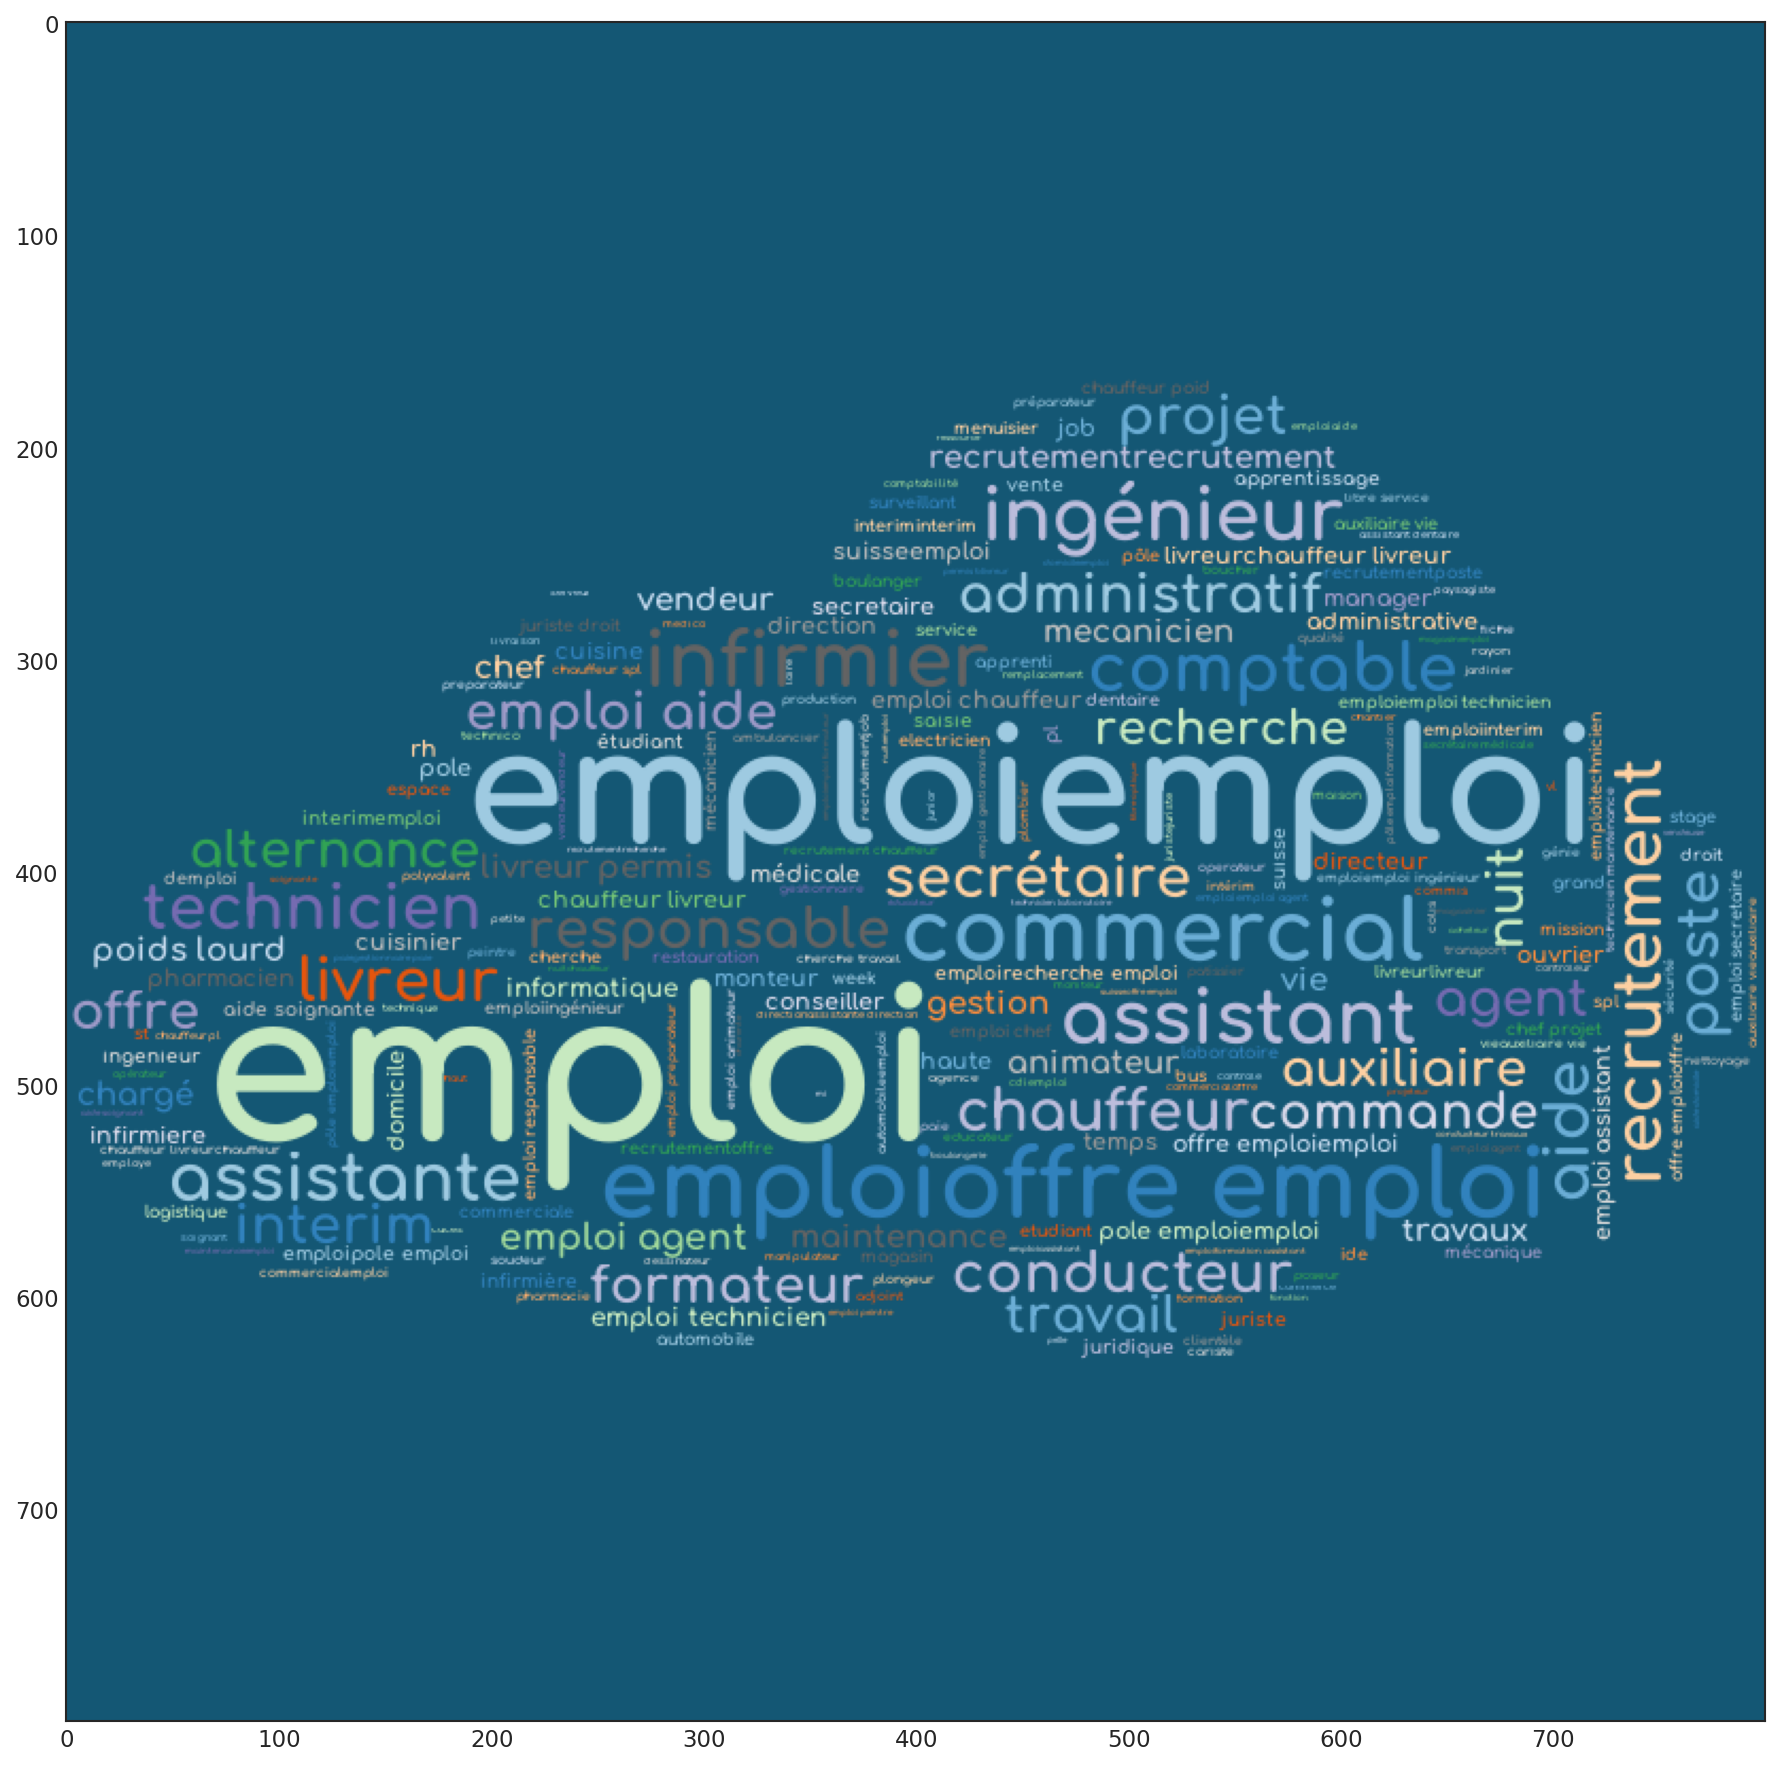

In [ ]:
font_path = '/content/drive/MyDrive/111_goldfinger/Comfortaa-Bold.ttf'
mask2 = np.array(Image.open("/content/drive/MyDrive/111_goldfinger/cloud2.jpg"))
wd = wordcloud.WordCloud(
                        # min_font_size=8,
                        #  max_font_size=25, 
                         max_words=1000, 
                         background_color="#145774", 
                         colormap='tab20c', 
                         mask = mask2,
                         font_path=font_path,
                         stopwords=STOP_WORDS)

# Generate word cloud 
cloud = wd.generate(''.join(data.keyword.values))




# Show word cloud with matplotlib 
my_dpi=150
plt.figure(figsize = (15,15), dpi = my_dpi)
# plt.figure()
plt.imshow(cloud)

# Remove trailing logs 
plt.show()

In [ ]:
cloud.to_file('/content/drive/MyDrive/111_goldfinger/data_collection/results/adwords.png')